# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 5: Minería de textos

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 29 de agosto de 2024


### 🚨 Se puede descargar manualmente el dataset mediante el enlace de abajo o ejecutando el código proporcionado. (Es necesario una cuenta y una key de kaggle). Es importante descomprimir el archivo en la carpeta data.

nltk, spacy, textblob

In [131]:
import os
import opendatasets as od
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from collections import Counter
import seaborn as sns
from matplotlib_venn import venn2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### 📂 Funciones utilitarias

In [132]:
def printText(df, stop = 10):
    for i, t in enumerate(df):
        print(i, t)
        if i >= stop:
            break

### 📩 Inciso 1. Descargar el archivo train.csv

In [133]:
if not os.path.isdir('nlp-getting-started'):
    od.download("https://www.kaggle.com/c/nlp-getting-started/data")

### 📩 Inciso 2. Carga de los datos

In [134]:
dataTrain = pd.read_csv('nlp-getting-started/train.csv')
dataTest = pd.read_csv('nlp-getting-started/test.csv')
dataSampleSubmission = pd.read_csv('nlp-getting-started/sample_submission.csv')

### 🧹 Inciso 3. Preprocesamiento y limpieza de datos

In [135]:
dataTrain.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [136]:
dataTrain.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [137]:
for i, element in enumerate(dataTrain.columns):
    print(str(i+1)+")📚["+element+"].Count:", dataTrain[element].count())

1)📚[id].Count: 7613
2)📚[keyword].Count: 7552
3)📚[location].Count: 5080
4)📚[text].Count: 7613
5)📚[target].Count: 7613


In [138]:
text = dataTrain['text']

Comenzando con este laboratorio lo primero que se hizo fue una limpieza y preprocesamiento de los datos, los cuales nos ayudarán para una mejor predicción de los mismos a la hora que nuestros modelos tengan que leer y clasificar los tweets.

Un poco de lo que realizamos para su limpieza fue:
- Eliminación de URLs presentes en los tweets para evitar que estos influyan en procesos posteriores
- Conversión a minúsculas de los textos para normalizar los datos.
- Eliminación de caracteres especiales para limpiar el texto y enfocarse en palabras
- Eliminación de patrones extraños como múltiples signos de exclamación, caracteres como **&** ya que se presentaban como **&amp** y saltos de líneas reemplazados por espacios.
- Reducción de repetición de letras consecutivamente así como **gooooaaaal** se normalizo a la palabra original **goal**.
- Eliminación de puntos y coma.
- Eliminación de espacios en blanco extras dejando solamente uno.
- Eliminación de stopwords, es decir palabras comunes que no aportan mucho significado pro sí solas, enfocandonos en palabras más significativas del texto.

Todo lo descrito anteriormente se puede ver el procedimiento a continuación:


#### 🖼️ Removiendo urls

In [139]:
textWithoutUrl = text.str.replace(r'http\S+|www\S+', '', regex=True)
printText(textWithoutUrl, 100)

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 Forest fire near La Ronge Sask. Canada
2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 13,000 people receive #wildfires evacuation orders in California 
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7 I'm on top of the hill and I can see a fire in the woods...
8 There's an emergency evacuation happening now in the building across the street
9 I'm afraid that the tornado is coming to our area...
10 Three people died from the heat wave so far
11 Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
12

#### 🔡 Convertir a minúsculas. 

In [140]:
textLowerCase = textWithoutUrl.str.lower()
textLowerCase.head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

#### 🤔 Removiendo caracteres especiales (@/#/')

In [141]:

textWithouthSpecialCharacthers = textLowerCase.str.replace('@', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('#', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace("'", "")
textWithouthSpecialCharacthers.head()

0    our deeds are the reason of this earthquake ma...
1               forest fire near la ronge sask. canada
2    all residents asked to shelter in place are be...
3    13,000 people receive wildfires evacuation ord...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### 👾 Removiendo patrones extraños

In [142]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\?+', '?', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\!+', '!', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('&amp;', 'and')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('\n', ' ')
printText(textWithouthSpecialCharacthers, stop=20)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask. canada
2 all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected
3 13,000 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy. 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas
7 im on top of the hill and i can see a fire in the woods...
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area...
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodi

#### 📚 Reduciendo la cantidad de letras repetidas

In [143]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(\.{3,})', 'THREEPOINTSIDENFIFIER', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(.)\1{'+str(2)+',}', r'\1' * 2, regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('THREEPOINTSIDENFIFIER', '...')
textWithouthSpecialCharacthers

0       our deeds are the reason of this earthquake ma...
1                  forest fire near la ronge sask. canada
2       all residents asked to shelter in place are be...
3       13,00 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610          m1.94 [01:04 utc]?5km s of volcano hawaii. 
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

#### 🛹 Quintando puntos y comas.

In [144]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('.',' ')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(',',' ')
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask  canada
2 all residents asked to shelter in place are being notified by officers  no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy  20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou  colorado springs areas
7 im on top of the hill and i can see a fire in the woods   
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area   
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodin

#### 🧹 Removiendo varios espacios en blanco y dejando solo uno

In [145]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\s{2,}', ' ', regex=True)
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask canada
2 all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
7 im on top of the hill and i can see a fire in the woods 
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area 
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining flooding florid

#### 🧹 Removiendo stopwords    

In [146]:
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

def removeStopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopWords]  
    return ' '.join(filtered_words)

textWithoutStopwords = textWithouthSpecialCharacthers.apply(removeStopwords)
printText(textWithoutStopwords, 100)

0 deeds reason earthquake may allah forgive us
1 forest fire near la ronge sask canada
2 residents asked shelter place notified officers evacuation shelter place orders expected
3 13 00 people receive wildfires evacuation orders california
4 got sent photo ruby alaska smoke wildfires pours school
5 rockyfire update => california hwy 20 closed directions due lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
7 im top hill see fire woods
8 theres emergency evacuation happening building across street
9 im afraid tornado coming area
10 three people died heat wave far
11 haha south tampa getting flooded hah- wait second live south tampa gonna gonna fvck flooding
12 raining flooding florida tampabay tampa 18 19 days ive lost count
13 flood bago myanmar arrived bago
14 damage school bus 80 multi car crash breaking
15 whats man?
16 love fruits
17 summer lovely
18 car fast
19 gooaal!
20 ridiculous
21 london cool ;)
22 lov

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [147]:
textWithoutStopwords = textWithoutStopwords.str.replace(r'[^\w\s]','',regex=True)

### Inciso 4. 🖼️ Frecuencia de palabras

In [148]:
nltk.download('punkt_tab')
tokenizedText = textWithoutStopwords.apply(word_tokenize)
allWords = [word for words in tokenizedText for word in words]
wordCounts = Counter(allWords)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       Word  Frequency
133    like        346
59       im        302
8      fire        252
234     get        229
164     new        224
781     via        220
25   people        196
748    news        194
356    dont        192
627     one        192


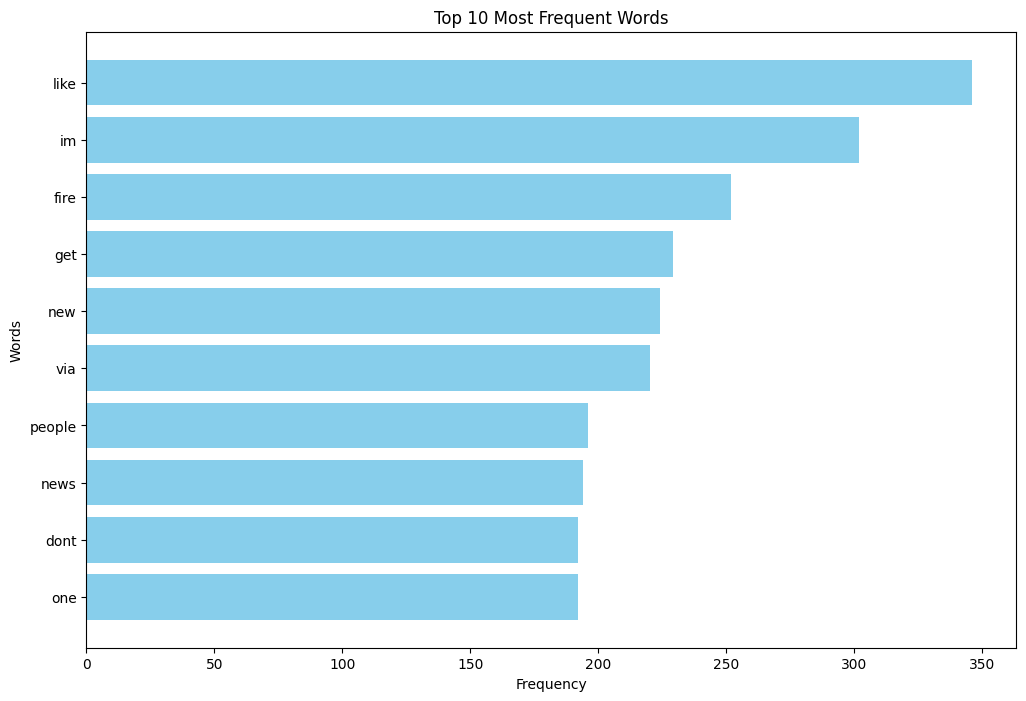

In [149]:
wordFreqDf = pd.DataFrame(wordCounts.items(), columns=['Word', 'Frequency'])
wordFreqDf = wordFreqDf.sort_values(by='Frequency', ascending=False)
print(wordFreqDf.head(10))
plt.figure(figsize=(12, 8))
plt.barh(wordFreqDf['Word'].head(10), wordFreqDf['Frequency'].head(10), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words')
plt.gca().invert_yaxis() 
plt.show()

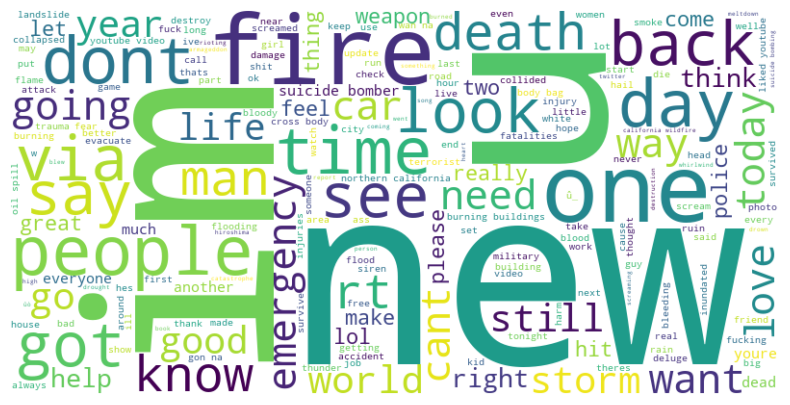

In [150]:
completeText = ' '.join(allWords)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(completeText)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

🔄 Generando 2-gramas...
📈 Mostrando los 10 2-gramas más frecuentes:
Label                   Disasters  No Disasters
2-gram                                         
(burning, buildings)         35.0          23.0
(california, wildfire)       34.0           NaN
(cross, body)                 1.0          38.0
(gon, na)                    11.0          32.0
(liked, youtube)              7.0          35.0
(northern, california)       41.0           NaN
(oil, spill)                 38.0           1.0
(suicide, bomber)            59.0           NaN
(wan, na)                     5.0          30.0
(youtube, video)              7.0          36.0


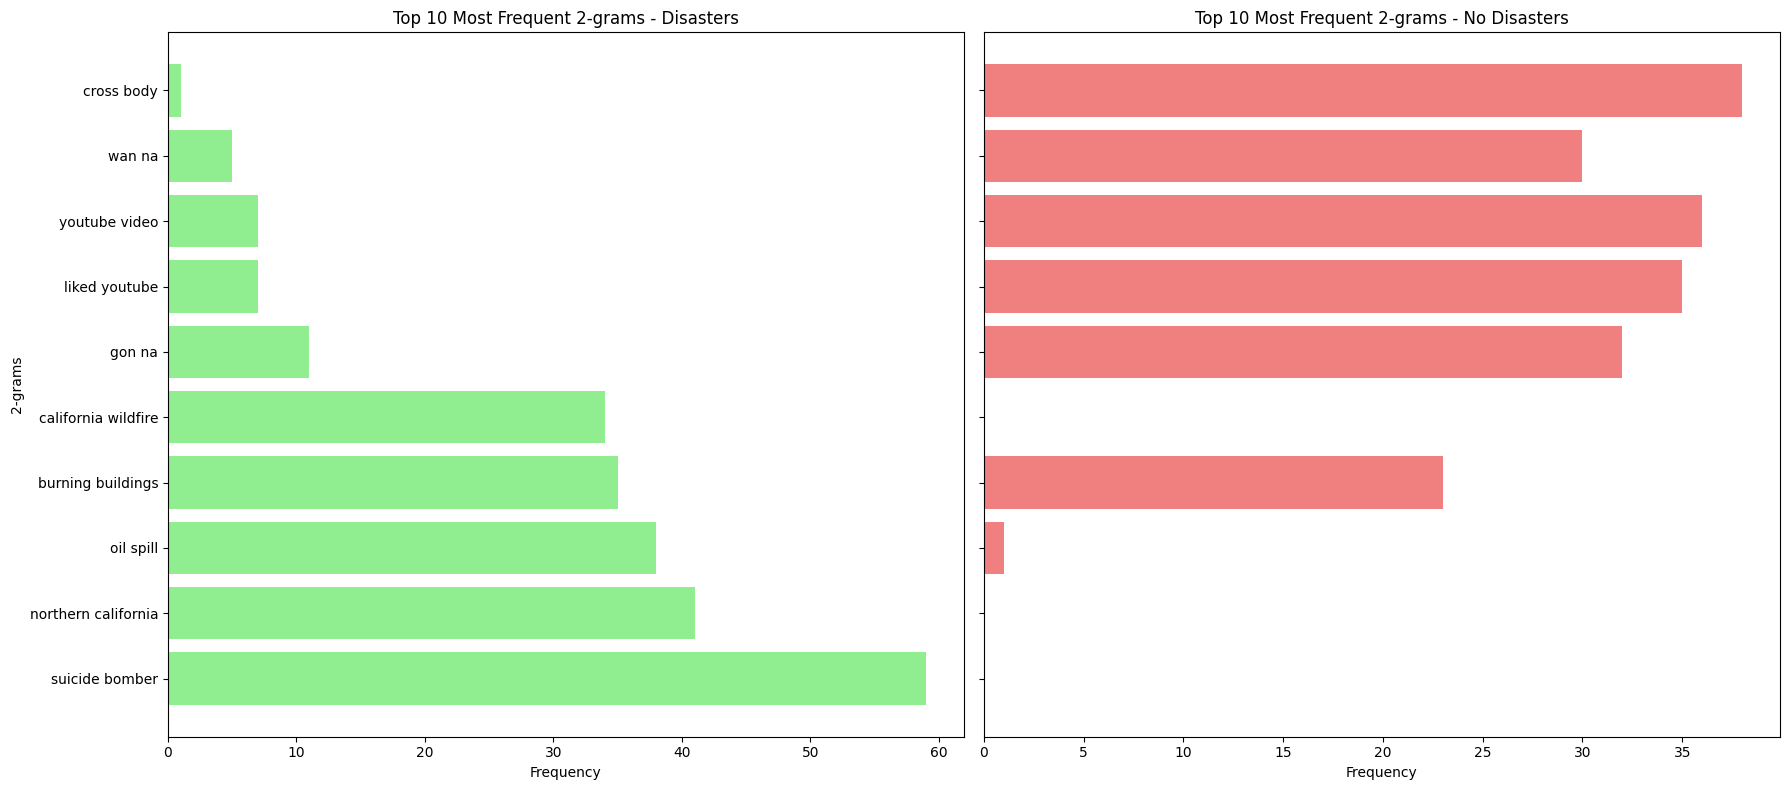

✅ Gráficos de 2-gramas generados.
🔄 Generando 3-gramas...
📈 Mostrando los 10 3-gramas más frecuentes:
Label                             Disasters  No Disasters
3-gram                                                   
(16yr, old, pkk)                       27.0           NaN
(bomber, detonated, bomb)              28.0           NaN
(homes, razed, northern)               28.0           NaN
(latest, homes, razed)                 28.0           NaN
(liked, youtube, video)                 7.0          35.0
(northern, california, wildfire)       29.0           NaN
(old, pkk, suicide)                    27.0           NaN
(pkk, suicide, bomber)                 28.0           NaN
(razed, northern, california)          27.0           NaN
(suicide, bomber, detonated)           30.0           NaN


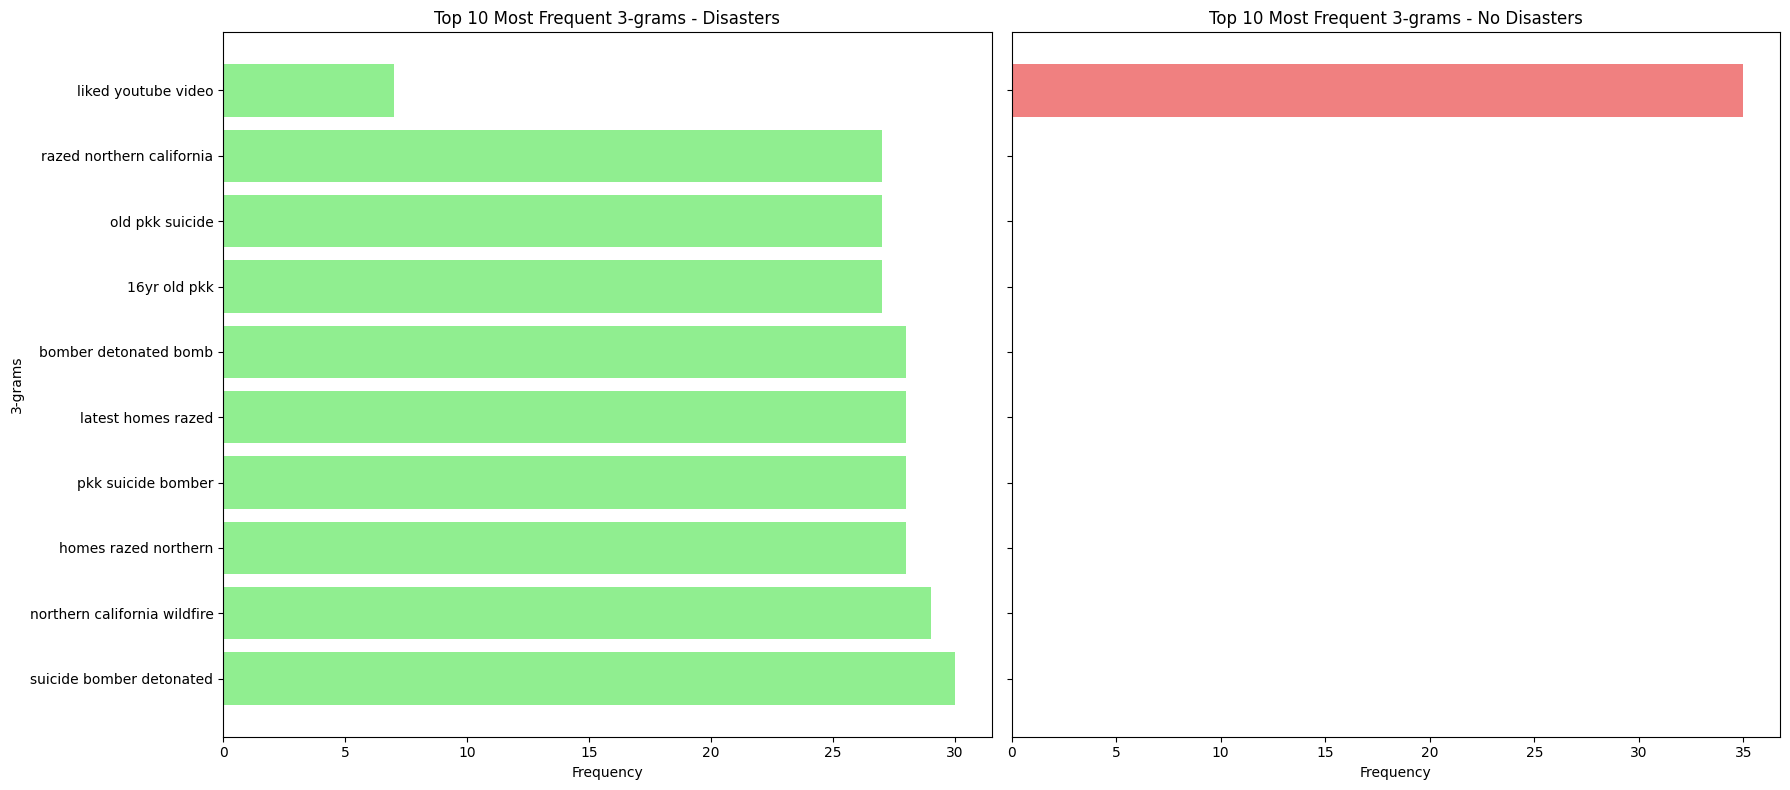

✅ Gráficos de 3-gramas generados.


In [151]:
def ngramAnalysis(tokenizedTextColumn, targetColumn, n=2):
    print(f"🔄 Generando {n}-gramas...")

    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def analyzeNgrams(texts, label):
        ngramsList = [ngram for tokens in texts for ngram in ngrams(tokens, n)]
        ngramCounts = Counter(ngramsList)
        ngramFreqDf = pd.DataFrame(ngramCounts.items(), columns=[f'{n}-gram', 'Frequency']).sort_values(by='Frequency', ascending=False)
        ngramFreqDf['Label'] = label
        return ngramFreqDf
    
    disasterNgramsDf = analyzeNgrams(disasterTweets, 'Disasters')
    nonDisasterNgramsDf = analyzeNgrams(nonDisasterTweets, 'No Disasters')
    
    topNgrams = pd.concat([disasterNgramsDf, nonDisasterNgramsDf]).groupby([f'{n}-gram'])['Frequency'].sum().sort_values(ascending=False).head(10).index
    topNgramsDf = pd.concat([disasterNgramsDf, nonDisasterNgramsDf])
    topNgramsDf = topNgramsDf[topNgramsDf[f'{n}-gram'].isin(topNgrams)]

    print(f"📈 Mostrando los 10 {n}-gramas más frecuentes:")
    print(topNgramsDf.groupby([f'{n}-gram', 'Label'])['Frequency'].sum().unstack())


    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    

    disasterSubset = topNgramsDf[topNgramsDf['Label'] == 'Disasters']
    axs[0].barh([' '.join(ngram) for ngram in disasterSubset[f'{n}-gram']], disasterSubset['Frequency'], color='lightgreen')
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel(f'{n}-grams')
    axs[0].set_title(f'Top 10 Most Frequent {n}-grams - Disasters')
    axs[0].invert_yaxis()
    
    nonDisasterSubset = topNgramsDf[topNgramsDf['Label'] == 'No Disasters']
    axs[1].barh([' '.join(ngram) for ngram in nonDisasterSubset[f'{n}-gram']], nonDisasterSubset['Frequency'], color='lightcoral')
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top 10 Most Frequent {n}-grams - No Disasters')
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print(f"✅ Gráficos de {n}-gramas generados.")

ngramAnalysis(tokenizedText, dataTrain['target'], n=2)
ngramAnalysis(tokenizedText, dataTrain['target'], n=3)

Para esta parte se realizó un procedimiento para ver la frecuencia de palabras, tanto de palabras solas, como formación de bigramas y trigramas, esto con el fin de encontrar que aportaba más para la predicción de textos y poder clasificarlas correctamente como un desaastre real o no. Con ello se puede ver que si hay ciertas palabras frecuentemente usadas en tweets sobre desastres, pero no se ve tan efectivo por lo que se procede a ver como es el comportamiento de los histogramas para bigramas y trigramas

Para ello se realizaron diferenctes bigramas y trigramas parra determinar que palabras son más frecuentes durante un desastre real y uno no real en conjunto. Como se puede apreciar en los bigramas hay ciertos pares de palabras que salen solo en desastres reales, pero hay algunos que se cuelan tanto en en desastres reales y no reales, por lo que se procedió a hacer trigramas.

En los trigramas ya se ve una diferencia más notable en donde tríos de palabras que salen frecuentemente en desastres reales ya no salen en alguno no real, por lo que sería más efectivo el uso de estos trigramas para una mejor identificación de desastres reales y no reales.

### 📚 Inciso 5. Análisis exploratorio

#### ✖️ Palabra más repetidas

In [152]:
def mostFrequentWords(tokenizedTextColumn, targetColumn):
    print("🔄 Analizando palabras más frecuentes por categoría...")
    
    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def countWords(texts):
        wordsList = [word for tokens in texts for word in tokens]
        wordCounts = Counter(wordsList)
        return wordCounts
    
    disasterWordCounts = countWords(disasterTweets)
    nonDisasterWordCounts = countWords(nonDisasterTweets)
    disasterWordFreqDf = pd.DataFrame(disasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    nonDisasterWordFreqDf = pd.DataFrame(nonDisasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    print("📈 Palabra más frecuente en desastres:")
    print(disasterWordFreqDf.head(1))
    
    print("📈 Palabra más frecuente en no desastres:")
    print(nonDisasterWordFreqDf.head(1))
    
    return disasterWordFreqDf, nonDisasterWordFreqDf

disasterWordFreqDf, nonDisasterWordFreqDf = mostFrequentWords(tokenizedText, dataTrain['target'])

🔄 Analizando palabras más frecuentes por categoría...
📈 Palabra más frecuente en desastres:
   Word  Frequency
8  fire        180
📈 Palabra más frecuente en no desastres:
    Word  Frequency
24  like        253


#### ☁️ Nube de las palabras más frecuentes

🌐 Generando nube de palabras para Desastres...


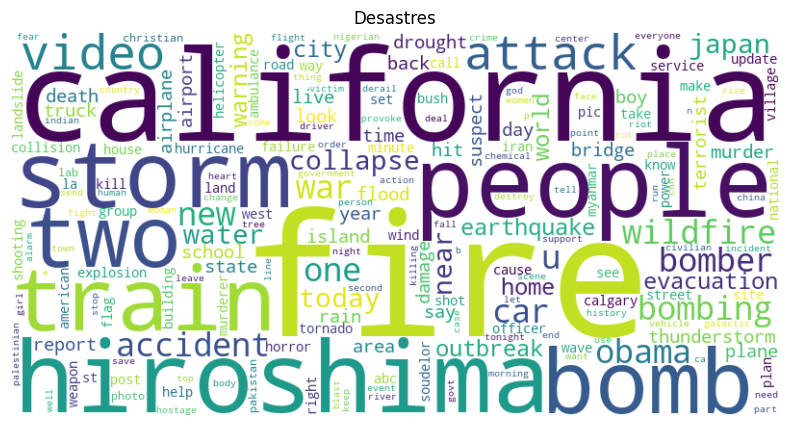

✅ Nube de palabras para Desastres generada.
🌐 Generando nube de palabras para No Desastres...


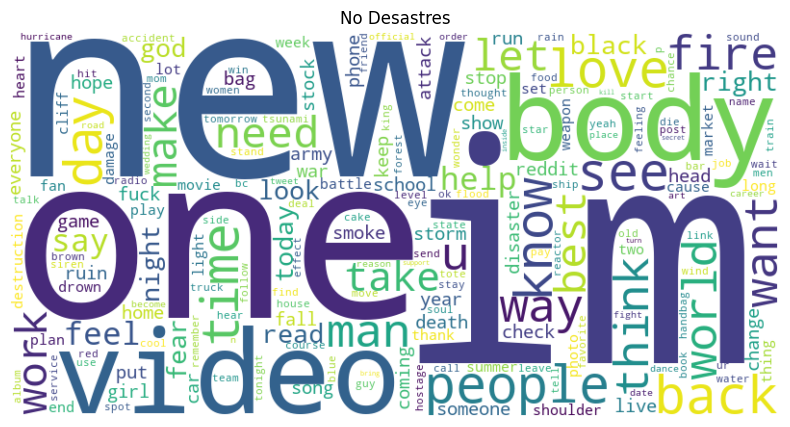

✅ Nube de palabras para No Desastres generada.


In [153]:
def plotWordCloud(wordFreqDf, title):
    print(f"🌐 Generando nube de palabras para {title}...")
    text = ' '.join(wordFreqDf['Word'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
    print(f"✅ Nube de palabras para {title} generada.")

plotWordCloud(disasterWordFreqDf, 'Desastres')
plotWordCloud(nonDisasterWordFreqDf, 'No Desastres')

Para nuestro análisis exploratorio realizamos diferentes wordclouds para visualizar que palabras eran más comunes en tweets de desastres reales y no reales, en la cual para desastres se pueden ver palabras significativas de desastres como 'fire', 'storm', 'bomb', 'hiroshima', 'evacuation', 'attack', etc.

#### 📊 Histogramas con las palabras más repetidas

📊 Generando histograma de palabras más frecuentes para Desastres...


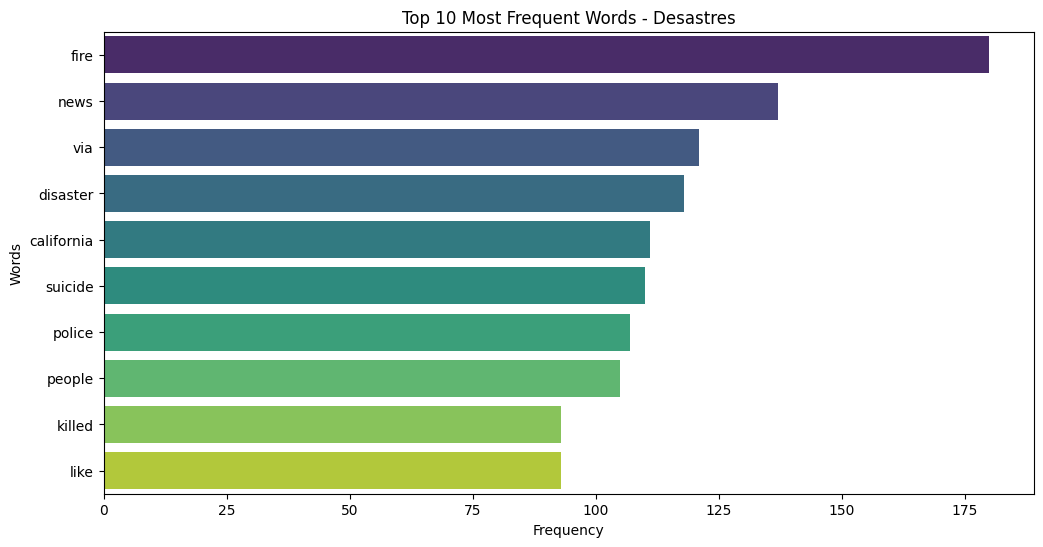

✅ Histograma de palabras más frecuentes para Desastres generado.
📊 Generando histograma de palabras más frecuentes para No Desastres...


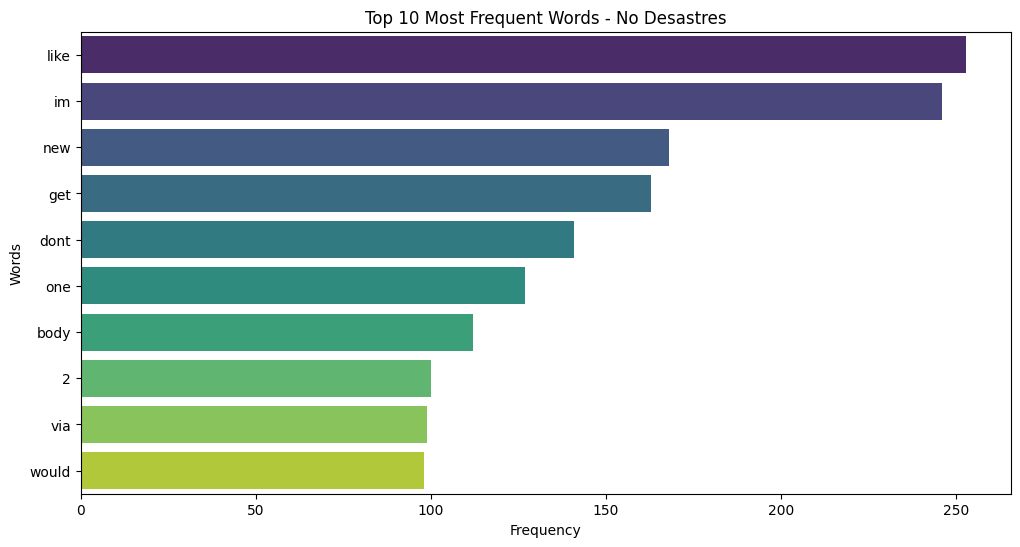

✅ Histograma de palabras más frecuentes para No Desastres generado.


In [154]:
def plotTopWordsHistogram(wordFreqDf, title):
    print(f"📊 Generando histograma de palabras más frecuentes para {title}...")
    topWords = wordFreqDf.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=topWords, hue='Word', palette='viridis', legend=False)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 10 Most Frequent Words - {title}')
    plt.show()
    
    print(f"✅ Histograma de palabras más frecuentes para {title} generado.")

plotTopWordsHistogram(disasterWordFreqDf, 'Desastres')
plotTopWordsHistogram(nonDisasterWordFreqDf, 'No Desastres')


Se continuo realizando histogramas del top 10 de esas palabras más frecuentes para desastres reales y no reales, nuevamente donde en desastres se pueden apreciar palabras significativas a desastres reales.

🔍 Identificando palabras comunes en ambas categorías...
📚 Palabras comunes en ambas categorías:
{'hailstorm', 'lane', 'happens', 'triggered', 'posted', 'gilbert23', 'sis', 'ban', 'cook', 'tooth', 'yall', 'tell', 'lightning', 'sinking', 'salem', 'gems', 'multiple', 'forbes', '99', 'goes', 'hiphop', 'multidimensi', 'acting', 'director', 'banned', '4wd', 'familia', 'industry', 'logic', 'ay', 'finger', 'mill', 'mess', 'gotten', 'japan', 'camping', 'charger', 'chairman', 'panicking', 'amongst', 'nc', 'cain', 'personal', 'drunk', 'city', 'wars', 'hit', 'raised', 'year', 'mariah', 'rifles', 'thus', 'kings', 'millions', 'stranded', 'suspected', 'motor', 'thats', 'bomber', 'mentions', 'hostages', 'score', 'farm', 'united', 'caused', 'not', 'network', 'avenue', 'may', 'pics', 'utter', 'reading', 'prophet', 'apartment', 'scotland', 'photo', 'sunset', 'tape', 'premium', 'rt_america', 'guy', 'brazil', 'young', 'warn', 'bombed', 'russia', 'violence', 'uk', 'officers', 'accident', 'improve', 'part', 

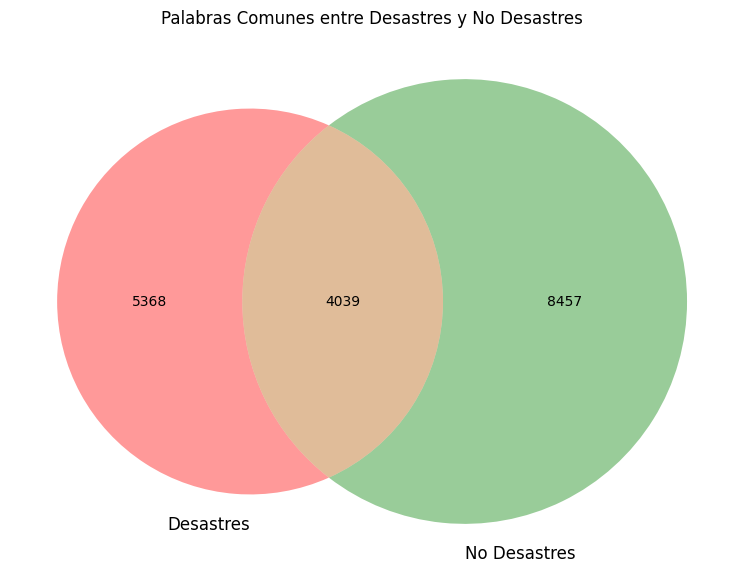

In [155]:
def commonWords(disasterWordFreqDf, nonDisasterWordFreqDf):
    print("🔍 Identificando palabras comunes en ambas categorías...")
    disasterWords = set(disasterWordFreqDf['Word'])
    nonDisasterWords = set(nonDisasterWordFreqDf['Word'])
    commonWords = disasterWords.intersection(nonDisasterWords)
    print("📚 Palabras comunes en ambas categorías:")
    print(commonWords)
    plt.figure(figsize=(10, 7))
    venn = venn2([disasterWords, nonDisasterWords], ('Desastres', 'No Desastres'))
    plt.title('Palabras Comunes entre Desastres y No Desastres')
    plt.show()

commonWords(disasterWordFreqDf, nonDisasterWordFreqDf)

Luego se realizó la clasificación de estas palabras donde se peude ver que buena cantidad de palabras están en común de ambos conjuntos pero algunas de ellas no tienen que ver en sí con palabras relacionadas a un desastre como tal, luego la mayoría de palabras están en el conjunto de no desastres y otra parte en el conjunto de desastres.

### 🧠 Inciso 6. Modelos

Se continuo con el entrenamiento de modelos de clasificación, para los cuales se dividieron en entrenamiento y prueba, 80% y 20% respectivamente. Para ello se realizaron tres modelos, uno de LSTM y embedding, otro CNN y el último SVM, para así ver cual era más efectivo en la clasificación de tweets.

#### 🗂️ Dividir en entrenamiento y prueba (80 - 20).

In [156]:
sentences = textWithoutStopwords.tolist()
targets = dataTrain['target'].tolist()
testSentences= dataTest['text'].tolist()

trainingSize = int(len(sentences) * 0.80)
trainingSentences = sentences[0:trainingSize]
testingSentences = sentences[trainingSize:]
trainingTargets = targets[0:trainingSize]
testingTargets = targets[trainingSize:]

trainingTargetsArray = np.array(trainingTargets)
testingTargetsArray = np.array(testingTargets)

print(trainingTargetsArray)
print(testingTargetsArray)

[1 1 1 ... 0 0 0]
[0 1 0 ... 1 1 1]


#### 🖼️ Tokenización y aplicación de padding.

In [157]:
tokenizer = Tokenizer(num_words = 500, oov_token='<OOV>')
tokenizer.fit_on_texts(trainingSentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
testing_sequences = tokenizer.texts_to_sequences(testingSentences)
testing_padded = pad_sequences(testing_sequences, maxlen=40, padding='post', truncating='post')
main_test_sequence=tokenizer.texts_to_sequences(testSentences)
main_test_padded=pad_sequences(main_test_sequence,maxlen=40,padding='post',truncating='post')

In [158]:
def add_embedding_noise(embedding, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(embedding), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    return embedding + noise

#### 🧠 LSTM y Embedding

In [159]:
firstModel = tf.keras.Sequential([
    layers.Embedding(500, 16, input_length=40),
    layers.Lambda(lambda x: add_embedding_noise(x, noise_factor=0.05)),
    layers.Bidirectional(layers.LSTM(8, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(8)),
    layers.Dense(72, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(36, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])


learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate)

firstModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
firstModel.summary()
firstModel.save('models/firstModel.h5')

c:\Users\lijv1.LINDA_HP\Documents\GitHub\Lab05_DSTC\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [160]:
earlyStopping=EarlyStopping(min_delta=0.001,patience=10)

In [161]:
history=firstModel.fit(
    training_padded,
    trainingTargetsArray,
    epochs=15,
    validation_data=(testing_padded,testingTargetsArray),
    callbacks=[earlyStopping]
)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4985 - loss: 0.8935 - val_accuracy: 0.5345 - val_loss: 0.7581
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5574 - loss: 0.7713 - val_accuracy: 0.5772 - val_loss: 0.7179
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7055 - loss: 0.6241 - val_accuracy: 0.6934 - val_loss: 0.6307
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7481 - loss: 0.5680 - val_accuracy: 0.7150 - val_loss: 0.5991
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7693 - loss: 0.5511 - val_accuracy: 0.7170 - val_loss: 0.5977
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7795 - loss: 0.5297 - val_accuracy: 0.6986 - val_loss: 0.5952
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7793 - loss: 0.5222 - val_accuracy: 0.7216 - val_loss: 0.5812
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7954 - loss: 0.4966 - val_acc

In [162]:
loss, accuracy = firstModel.evaluate(testing_padded, testingTargetsArray)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7172 - loss: 0.6010
Test Loss: 0.5985
Test Accuracy: 0.7163


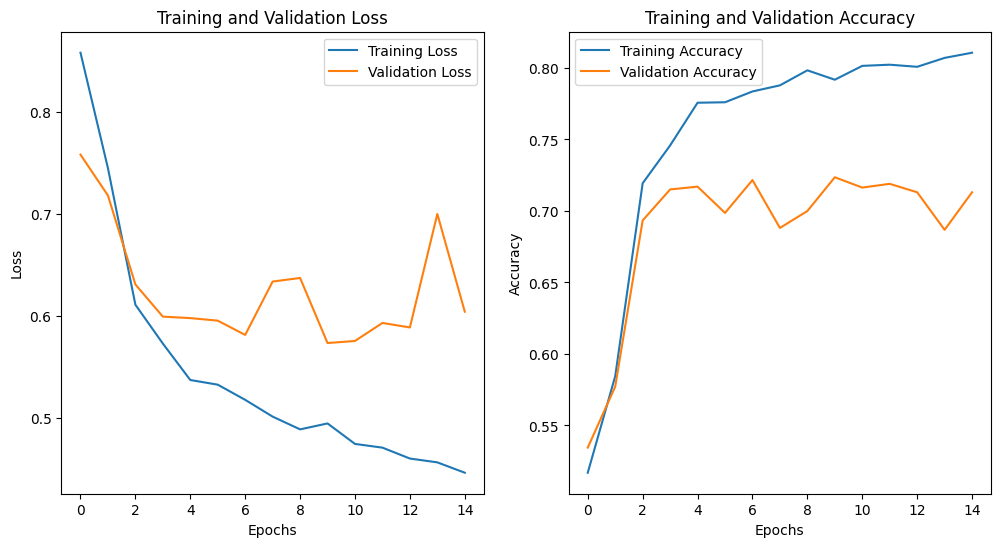

In [163]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2) # Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Para el primer modelo entrenado para clasificar tweets se realizó una red neuronal LSTM con embedding, la cual no salió nada mal con accuracy de del 71.63% en el conjunto de prueba, el cual es bastante bueno, así también se puede ver esto reflejado en las gráficas de arriba, donde en el loss ambos conjuntos convergen bastante rápido.

#### 🧠 CNN

In [164]:
secondModel = tf.keras.Sequential([
    layers.Embedding(500, 16, input_length=40),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
secondModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
secondModel.summary()
secondModel.save('models/secondModel.h5')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [165]:
earlyStopping = EarlyStopping(min_delta=0.001, patience=10)

In [166]:
history = secondModel.fit(
    training_padded,
    trainingTargetsArray,
    epochs=15,
    validation_data=(testing_padded, testingTargetsArray),
    callbacks=[earlyStopping]
)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5701 - loss: 0.7232 - val_accuracy: 0.7190 - val_loss: 0.5786
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7663 - loss: 0.5232 - val_accuracy: 0.7275 - val_loss: 0.5490
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8073 - loss: 0.4597 - val_accuracy: 0.7190 - val_loss: 0.5593
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8161 - loss: 0.4393 - val_accuracy: 0.7321 - val_loss: 0.5534
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8175 - loss: 0.4284 - val_accuracy: 0.7170 - val_loss: 0.5605
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8322 - loss: 0.4071 - val_accuracy: 0.7216 - val_loss: 0.5650
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8368 - loss: 0.3871 - val_accuracy: 0.7150 - val_loss: 0.5904
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8585 - loss: 0.3592 - val_accuracy: 0.

In [167]:
loss, accuracy = secondModel.evaluate(testing_padded, testingTargetsArray)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7093 - loss: 0.7807
Test Loss: 0.7707
Test Accuracy: 0.7072


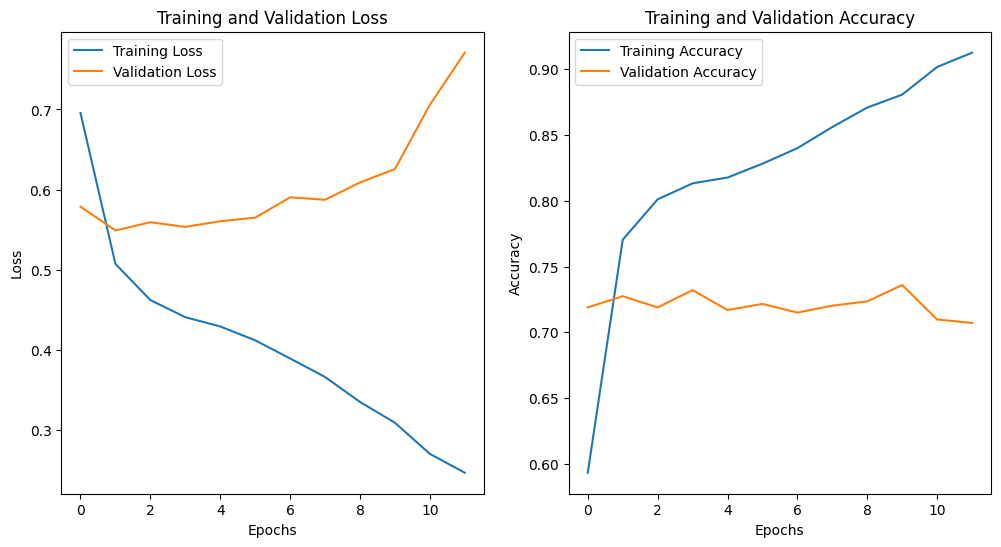

In [168]:
# Visualización de las métricas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2) # Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Luego se procedió a realizar una red neuronal CNN, la cual tambien obtuvo un accuracy bastante bueno, aunque ligeramente menor al del modelo anterior, el cual es del 70.72%, el cual podríamos decir que es bastante alto, igualmente en las gráficas anteriores se puede ver como ambos conjutnos convergen en las primeras épocas.

#### 🟢 SVM

In [169]:
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(sentences)

X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [170]:
# Predicción y evaluación del modelo
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7708

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       874
           1       0.77      0.66      0.71       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



Por último se procedió a realizar un modelo SVM con un kernel linear, el cual curiosamente salió con el mejor accuracy, superando por un casi 7% a ambos modelos anteriores, el cual fue del 77.08%. 

Con estos 3 modelos se procede a realizar la clasificación de los primeros 6 tweets del conjunto de datos, para ver que modelo es el que es más preciso y no se equivoca tanto.

### Inciso 7. ✅ Clasificación de tweets

In [174]:
first_10_tweets = dataTest['text'].head(6).tolist()
first_10_sequences = tokenizer.texts_to_sequences(first_10_tweets)
first_10_padded = pad_sequences(first_10_sequences, maxlen=40, padding='post', truncating='post')
predictions = firstModel.predict(first_10_padded)
predictions2 = secondModel.predict(first_10_padded)
predictions3 = svm_model.predict(vectorizer.transform(first_10_tweets))

print("🔮 Predicciones del primer modelo:\n")
for i, prediction in enumerate(predictions):
    print(f"Tweet: {first_10_tweets[i]}")
    if prediction[0] > 0.5:
        print("Predicción: Este tweet se refiere a un desastre.")
    else:
        print("Predicción: Este tweet NO se refiere a un desastre.")
    print("\n")

print("🔮 Predicciones del segundo modelo:\n")
for i, prediction in enumerate(predictions2):
    print(f"Tweet: {first_10_tweets[i]}")
    if prediction[0] > 0.5:
        print("Predicción: Este tweet se refiere a un desastre.")
    else:
        print("Predicción: Este tweet NO se refiere a un desastre.")
    print("\n")

print("🔮 Predicciones del modelo SVM:\n")
for i, prediction in enumerate(predictions3):
    print(f"Tweet: {first_10_tweets[i]}")
    if prediction == 1:
        print("Predicción: Este tweet se refiere a un desastre.")
    else:
        print("Predicción: Este tweet NO se refiere a un desastre.")
    print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
🔮 Predicciones del primer modelo:

Tweet: Just happened a terrible car crash
Predicción: Este tweet se refiere a un desastre.


Tweet: Heard about #earthquake is different cities, stay safe everyone.
Predicción: Este tweet se refiere a un desastre.


Tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Predicción: Este tweet se refiere a un desastre.


Tweet: Apocalypse lighting. #Spokane #wildfires
Predicción: Este tweet NO se refiere a un desastre.


Tweet: Typhoon Soudelor kills 28 in China and Taiwan
Predicción: Este tweet NO se refiere a un desastre.


Tweet: We're shaking...It's an earthquake
Predicción: Este tweet se refiere a un desastre.


🔮 Predicciones del segundo modelo:

Tweet: Just happened a terrible car crash
Predicción: Este tweet NO se refiere a un desastre.


Tweet: Heard about #earthquake is different ci

Como se puede apreciar, si leemos cada tweet podemos determinar que el único tweet no referido a un desastre es el cuarto, y leugo el resto son desastres reales. En base a esto podemos ver que que el modelo 1, se confundio una vez, en el tweet 5 diciendo que este no es un desastre, mientras si lo fue. El modelo 2 se confundió dos veces, en el primer tweet diciendo que no es un desastre, y también el en quinto tweet diciendo que tampoco es un desastre. Por último, el SVM no se confundió ninguna vez, indicando correctamente que el cuarto no era un desastre y el resto si lo eran. 

Podemos ver que el comportamiento de cada modelo corresponde correctamente a su test accuracy, siendo el CNN más bajo confuendiendose 2 veces, el LSTM el que le sigue con casi 1% más de accuracy, confundiendose una vez, y con SVM el más alto no confundiendose ninguna vez. Por lo que a pesar de todo los 3 modelos salieron con un accuracy bastante bueno, siendo el de SVM el mejor siendo el más acertvo con 6 tweets.

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


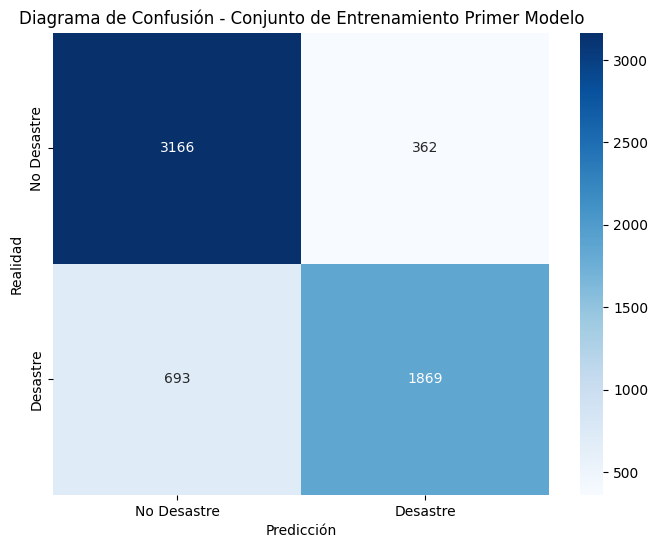

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


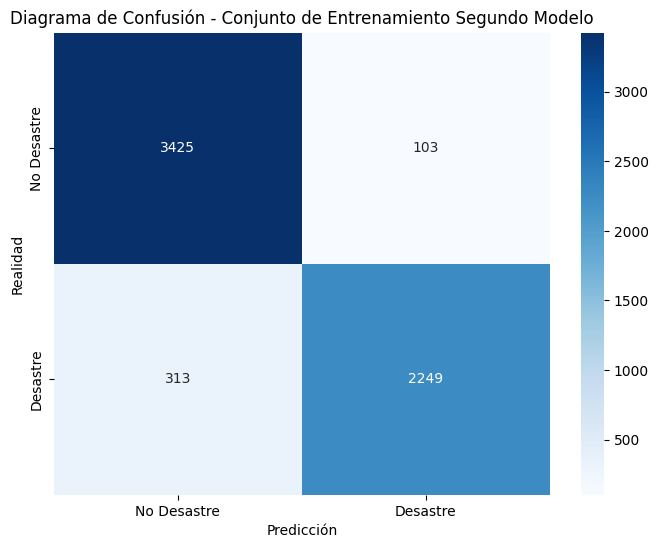

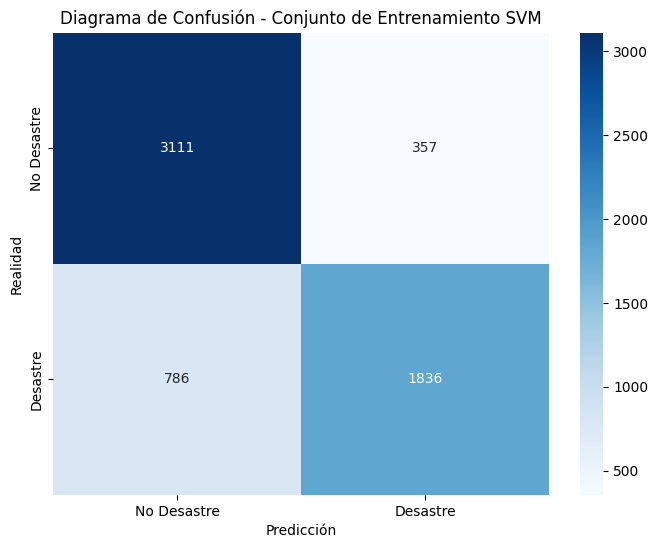

In [172]:
training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
predictions_train = firstModel.predict(training_padded)
predictions_train = (predictions_train > 0.5).astype(int) 
true_labels_train = np.array(trainingTargets) 
cm_train = confusion_matrix(true_labels_train, predictions_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Diagrama de Confusión - Conjunto de Entrenamiento Primer Modelo')
plt.show()

training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
predictions_train = secondModel.predict(training_padded)
predictions_train = (predictions_train > 0.5).astype(int) 
true_labels_train = np.array(trainingTargets) 
cm_train = confusion_matrix(true_labels_train, predictions_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Diagrama de Confusión - Conjunto de Entrenamiento Segundo Modelo')
plt.show()

y_pred = svm_model.predict(X_train)
cm_train_svm = confusion_matrix(y_train, y_pred)

# Graficamos la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Diagrama de Confusión - Conjunto de Entrenamiento SVM')
plt.show()

Por útlimo viendo estas matrices de confusión podemos notar que en el primer modelo el desempeño es bastante razonable, aunque nos da un número considerable de falsos degativos (693), lo que nos dice que clasifica varios desastres como no desastres.

Nuestro segundo modelo podemos ver que el número de falsos negativos es menor (312) als igual que de falsos positivos (313). Por lo que aunque su presición es algo más baja puede que sea mejor en algunsocasos de ser mejor en la clasificación entre estos dos conjuntos.

Este útlimo modelo de SVM es bastante similar a LSTM pero ligeramente tiene más falsos negativos (786) donde podría llegar a clasificar mal algunos desastres reales.

Lo que nos suguiere que a pesar que SVM tiene un mayor accuracy es bueno prediciendo en la clase mayoritarua, el cual es un "No desastre", pero comete varios falsos negativos y falsos positivos, lo que esta sesgando hacia la clase mayoritaria y por ello tiene un acccuracy alto. Por ello posiblemente a la hora de clasificar mayor cantidad de datos puede que CNN lo haga mejor ya que por su matriz de confusión es posible que sea mejor a la hora de identificar tanto "Desastre" como "No Desastre".